Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Se configuró el codigo para que trabaje con la grafica y se modificaron los parametros de seq_lenght, num_layers y num_heads para obtener mejores predicciones

In [1]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [2]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1) #Eliminar la primera columna que tiene la etiqueta

In [4]:
#Nos saltamos la parte del codigo que genera datos porque nosotros ya tenemos datos reales
#Debemos convertir nuestros datos en una ventana de datos deslizantes. Esto es, obtener una matriz dividiendo los datos en epocas de 10 dias y obtener los target para cada una de esas epocas
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Dividimos en epocas de 10 dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [5]:
#Despues necesitamos definir una clase que permita tratar los datos para poder usar DataLoader de pytorch.
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset): #Heredamos caracteristicas de Dataset
    def __init__(self, sequences, next_points): #Determina que parametros debemos pasar al crear una instancia
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self): #Nos dice la longitud de nuestros datos de secuancia
        return len(self.sequences)

    def __getitem__(self, idx): #Nos da cualquier epoca que queramos y su target asociado
        return self.sequences[idx], self.next_points[idx]

In [6]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512): #Se definen los parametros del modelo. Una capa, 2 cabezas de atencion
        super(TransformerModel, self).__init__() #Llama al init de la clase padre, que es el constructor del modelo. Es necesario para crear modelos personalizados
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward) #Define una capa
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers) #Crea el transformer definido anteriormente
        self.fc_out = nn.Linear(input_size * sequence_length, 1) #Capa fully connected que toma la salida del trandormer (10 valores) y regresa un unico valor (prediccion, next point)

    
    #Aqui se define como fluye la informacion a traves del modelo. Pasar datos por la red y obtener predicciones
    def forward(self, src): #src es el tensor de entrada
        # Reshape to match the input dimensions
        src = src.reshape(-1, self.sequence_length, 1)  #-1 hace que se ajuste automaticamente el tamaño del batch
        src = src.flatten(start_dim=1) #Aplana la dimension 1D
        src = src.unsqueeze(0)  # Add batch dimension *
        out = self.transformer_encoder(src) #Aplica el modelo en la secuencia
        out = out.squeeze(0)  # Remove batch dimension *
        return self.fc_out(out) #Le aplica la capa de salida

In [7]:
# Preparamos los datos
sequences, next_points = Epocas() #Cargamos nuestras epocas de 10 dias(Shanghai_epocas) y nuestros target (Shanghai_targets)
dataset = TimeSeriesDataset(sequences, next_points) #Asignamos las funciones a nuestros datos para poder manipularlos
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #Divide los datos en batches y los revuelve

In [8]:
#Entrenamiento del modelo
model = TransformerModel().to(device) #Se llama al modelo definido
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):  # Numero de epocas, esto es numero de veces que todos los datos pasan por el modelo
    for seq, next_point in dataloader: #Itera a traves de los batches
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) #Pone los datos en forma decimal 
        output = model(seq) #Se pasan las secuencias al modelo para obtener la prediccion output
        loss = criterion(output, next_point) #Se calcula la perdida 
        optimizer.zero_grad() #Se limpian los gredientes de la iteracion anterior
        loss.backward() #Back propagation. Gradientes de la perdida con respecto a los pesos y bias
        optimizer.step() #Actualiza los parametros del modelo con base en los gradientes
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 9411804.0
Epoch 2, Loss: 7372778.0
Epoch 3, Loss: 9075940.0
Epoch 4, Loss: 7811729.5
Epoch 5, Loss: 10044816.0
Epoch 6, Loss: 8655579.0
Epoch 7, Loss: 8683650.0
Epoch 8, Loss: 10010609.0
Epoch 9, Loss: 8681760.0
Epoch 10, Loss: 10461237.0
Epoch 11, Loss: 8598922.0
Epoch 12, Loss: 9935422.0
Epoch 13, Loss: 8238621.5
Epoch 14, Loss: 9841918.0
Epoch 15, Loss: 7551155.0
Epoch 16, Loss: 8957685.0
Epoch 17, Loss: 7862212.0
Epoch 18, Loss: 7047543.5
Epoch 19, Loss: 7911228.5
Epoch 20, Loss: 8945724.0
Epoch 21, Loss: 7735189.5
Epoch 22, Loss: 8221513.5
Epoch 23, Loss: 6734068.5
Epoch 24, Loss: 7932887.5
Epoch 25, Loss: 8947937.0
Epoch 26, Loss: 8515698.0
Epoch 27, Loss: 7021363.5
Epoch 28, Loss: 6538218.0
Epoch 29, Loss: 7268225.0
Epoch 30, Loss: 7350722.5
Epoch 31, Loss: 7403737.5
Epoch 32, Loss: 7445578.5
Epoch 33, Loss: 6579298.0
Epoch 34, Loss: 7740076.0
Epoch 35, Loss: 6583619.0
Epoch 36, Loss: 7610999.0
Epoch 37, Loss: 7350628.0
Epoch 38, Loss: 6369216.0
Epoch 39, Loss: 71

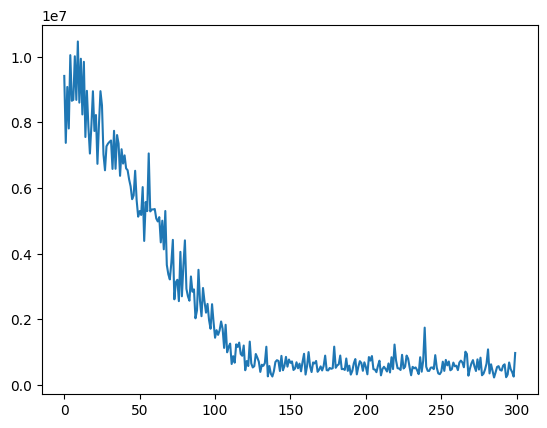

In [9]:
import matplotlib.pyplot as plt
# Desconectar cada loss individualmente
losses = [loss.detach().cpu().item() for loss in losses]
# Ahora puedes convertirlo a array
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [44]:
#Veamos como predice el modelo
test_seq = torch.tensor(sequences[0]).float()
test_seq = test_seq.unsqueeze(0)  #Añades una dimensión de batch aquí
test_seq = test_seq.to(device)
with torch.no_grad():
    predicted_point = model(test_seq)
print("Prediccion(dato siguiente):", predicted_point.item())
print('Dato siguiente real:',next_points[0])


Prediccion(dato siguiente): 2854.819580078125
Dato siguiente real: 1204.39404296875


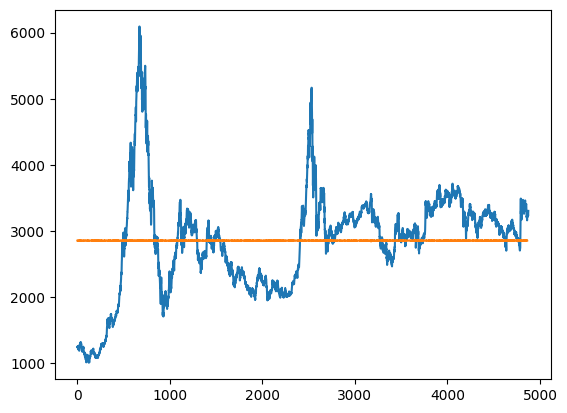

[2854.7265625, 2855.091064453125, 2854.564453125, 2855.86474609375, 2854.144775390625, 2854.2197265625, 2851.5234375, 2850.599853515625, 2854.3623046875, 2851.844970703125, 2853.972412109375, 2853.8818359375, 2853.780517578125, 2854.57568359375, 2853.405517578125, 2854.78369140625, 2854.19970703125, 2852.796875, 2854.32080078125, 2854.49462890625, 2853.796142578125, 2855.214599609375, 2850.92431640625, 2853.940673828125, 2853.80322265625, 2855.15087890625, 2854.28076171875, 2852.859375, 2851.706298828125, 2854.712890625, 2850.81298828125, 2854.8701171875, 2853.962890625, 2851.70263671875, 2854.84619140625, 2852.788330078125, 2854.78173828125, 2851.079833984375, 2852.19140625, 2855.114013671875, 2853.857666015625, 2852.87744140625, 2855.34326171875, 2855.64208984375, 2854.936767578125, 2854.40576171875, 2855.118408203125, 2855.81201171875, 2854.771484375, 2852.94921875, 2854.54150390625, 2854.1396484375, 2855.01953125, 2854.404296875, 2854.46142578125, 2854.124755859375, 2853.9682617187

In [45]:
#Comparemos los datos reales con las predicciones que hace el modelo con los mismos
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    test_seq = test_seq.to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


plt.plot(ShanghaiDat)
plt.plot(predicciones)
plt.show()
print(predicciones)